<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/Classifier_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1)
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])


In [4]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


label :  5


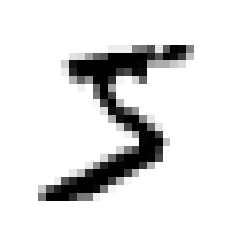

In [16]:
#데이터 확인
import matplotlib.pyplot as plt
import matplotlib as mpl

some_digit = X[0]
some_label = y[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show
print("label : ", some_label)

In [6]:
#레이블 타입 변환
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [ ]:
from sklearn.linear_model import SGDClassifier

#이진분류기 y = 5 인경우만
y_train_5 = y_train == 5
y_test_5 = y_test == 5
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
print(sgd_clf.predict([some_digit]))

[ True]


In [ ]:
#정확도 측정 구현
#k개 fold 교차검증
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

from sklearn.model_selection import cross_val_score
print(cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy'))

0.9669
0.91625
0.96785
[0.95035 0.96035 0.9604 ]


In [ ]:
#5가 아닐확률 : 90%
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [ ]:
#오차 행렬을 이용한 성능 평가
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))

In [ ]:
from sklearn.metrics import precision_score, recall_score
#정밀도 평가
print(precision_score(y_train_5, y_train_pred)) # == 3530 / 3530 + 687
#민감도 평가
print(recall_score(y_train_5, y_train_pred)) # == 3530 / 3530 + 1891

0.8370879772350012
0.6511713705958311


In [ ]:
#F1 점수
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.7325171197343846


In [ ]:
#결정 함수, 결정 임계값 측정
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

#임계값 상승
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)
#임계값을 높이면 재현율이 줄어든다.

[2164.22030239]
[ True]
[False]


In [ ]:
#모든 훈련 세트 샘플 점수 구하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

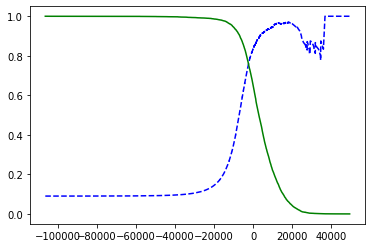

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

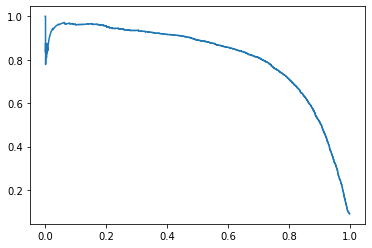

In [ ]:
#재현율에 대한 정밀도
plt.plot(recalls[:-1], precisions[:-1], "-")
plt.show()

In [ ]:
#정밀도 90%를 달성하는 분류기
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))
#낮은 재현율에서의 높은 정밀도는 의미없다!

0.9000345901072293
0.4799852425751706


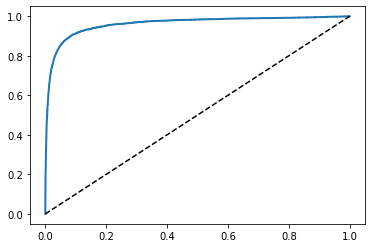

In [ ]:
#TPR 에 대한 FPR 의 곡선그래프
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], "k--")

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
#AUC로 분류기 성능측정
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_5, y_scores))

0.9604938554008616


In [ ]:
#RandomForestClassifier을 훈련시켜 SGDClassifier의 ROC곡선과 ROC AUC점수를 비교한다.
from sklearn.ensemble import RandomForestClassifier

#모델생성
forest_clf = RandomForestClassifier(random_state=42)
#훈련
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method="predict_proba")

In [ ]:
#양성 클래스에 대한 확률을 점수로 사용한다.
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forset, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

#곡선을 그린다
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forset, "random forest")
plt.show()

#Random forest classifier가 훨씬 좋은 모습을 보여준다.

In [ ]:
#SVM을 통해서 다중 분류기 테스트
from sklearn.svm import SVC
svm_clf = SVC()
#내부적으로 N (N-1) 개의 이진 분류기 생성
svm_clf.fit(X_train, y_train)
print(svm_clf.predict([some_digit]))

In [ ]:
#각 클래스의 결정 점수 확인
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)
#9.xx인 가장높은점수가 5

In [ ]:
#SVC 기반 OvR 분류기를 사용하는 다중 분류기전략
'''
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))
'''

In [ ]:
#SGD 분류기 : 직접으로 다중 클래스 분류가능
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

print(sgd_clf.decision_function([some_digit]))
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy'))

[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]
[0.87365 0.85835 0.8689 ]


[0.8983 0.891  0.9018]
[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


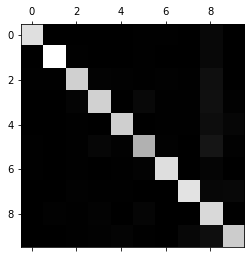

In [ ]:
#입력의 스케일을 조정
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

#정확도 점수 측정
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy'))

#confusion matrix를 통해 오차를 확인한다.
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

#이미지로 변환
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
#특정 클래스 데이터 개수가 적거나, 분류기가 특정 클래스를 잘 분류하지못하는 경우를 확인한다.

#confusion matrix에 각 클래스의 데이터개수를 나누어서 데이터를 비율화 한다.
row_soms = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [14]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [ ]:
#개개의 에러 분석하기
cl_a, cl_b = 6, 8
X_aa = X_train[(y_train == cl_a) && (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) && (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) && (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) && (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))


plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

In [9]:
#다중 레이블 분류
#다중 레이블 분류를 지원하는 KNeighborsClassfier 사용
from sklearn.neighbors import KNeighborsClassifier

#7, 8, 9
y_train_large = (y_train >= 7)
#홀수
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
# 5
print(knn_clf.predict([some_digit]))
#false large, true odd

[[False  True]]


In [ ]:
#다중 레이블 분류기 평가
#교차검증
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, y_multilabel, cv=3)
print(f1_score(y_multilabel, y_train_knn_pred, average="marcro"))
#print(f1_score(y_multilabel, y_train_knn_pred, average="weight"))

In [12]:
#다중 출력 분류
#이미지의 잡음을 제거하는 시스템을 만들어보자

#노이즈 이미지 생성 및 타깃 이미지
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

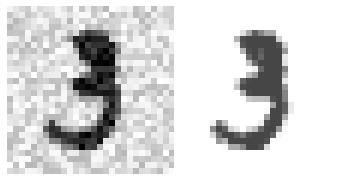

In [26]:
plot_digits([X_train_mod[some_index], y_train_mod[some_index]])
some_index = 10
knn_clf.fit(X_train_mod, y_train_mod)

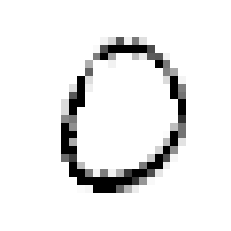

In [27]:
import matplotlib

clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)